Added a generate_machine_capacity function that creates a realistic pattern of machine operation:

100% capacity (40% of the time)
75% capacity (30% of the time)
50% capacity (20% of the time)
Idle/0% capacity (10% of the time)
Durations for each capacity level vary randomly


Incorporated the machine capacity into the temperature calculation. When the machine is running at higher capacity, it generates more heat.
Adjusted the temperature range to account for higher temperatures during full capacity operation (now 0°C to 60°C).
Added a 'capacity' column to the output DataFrame.
Updated the plotting code to show both temperature and machine capacity for a one-week period, allowing you to see how machine operation affects temperature.

This data now includes:

Minute-by-minute readings
Yearly seasonality (warmer in summer, cooler in winter)
Daily seasonality (warmer during day, cooler at night)
Machine capacity variations (100%, 75%, 50%, idle)
Realistic transitions between different capacity levels
The effect of machine capacity on temperature



Modified the generate_machine_capacity function to take date_rng as an input.
Added a check for Sundays in the generate_machine_capacity function:

On Sundays, the machine is mostly idle (90% chance) or operating at very low capacity (25% capacity, 10% chance).
The duration for Sundays is set to a full day (24 hours * 60 minutes).


For non-Sunday days, the original logic for capacity levels and durations is maintained.

This modification will result in a clear weekly pattern in the data, with Sundays typically showing lower temperatures due to reduced machine activity. This pattern will be visible in both the capacity and temperature plots.
When you run this code, you should see:

In the one-week plot, Sundays will typically show very low capacity and correspondingly lower temperatures.
In the full-year plot, you'll notice regular dips in temperature, which will largely correspond to Sundays.

This more realistic data set, including the Sunday holiday effect, will be useful for testing anomaly detection algorithms, as it introduces a regular pattern that the algorithm should learn to expect.

/tmp/ipykernel_33/3902508824.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_rng = pd.date_range(start=start_date, end=end_date, freq=freq)


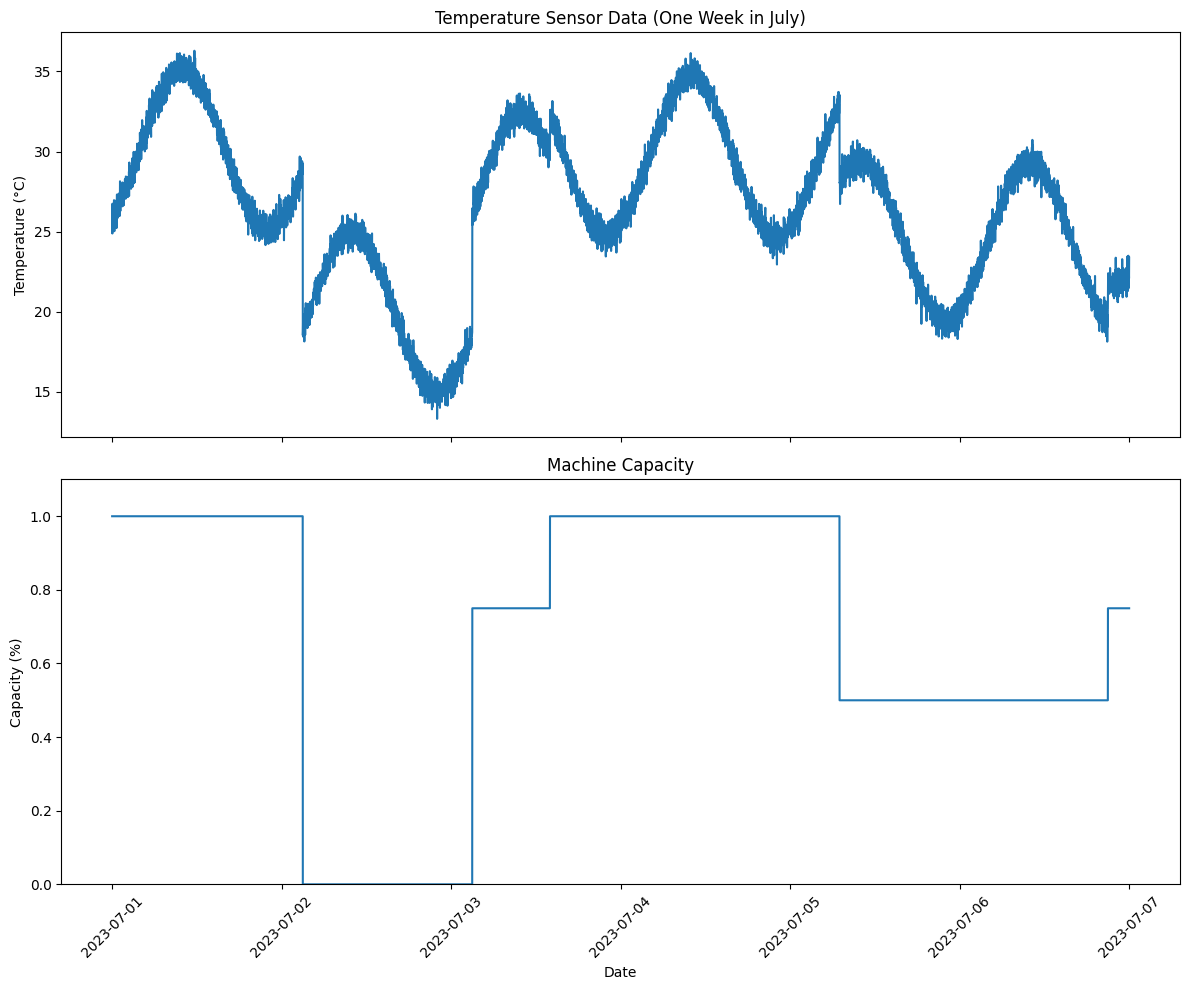

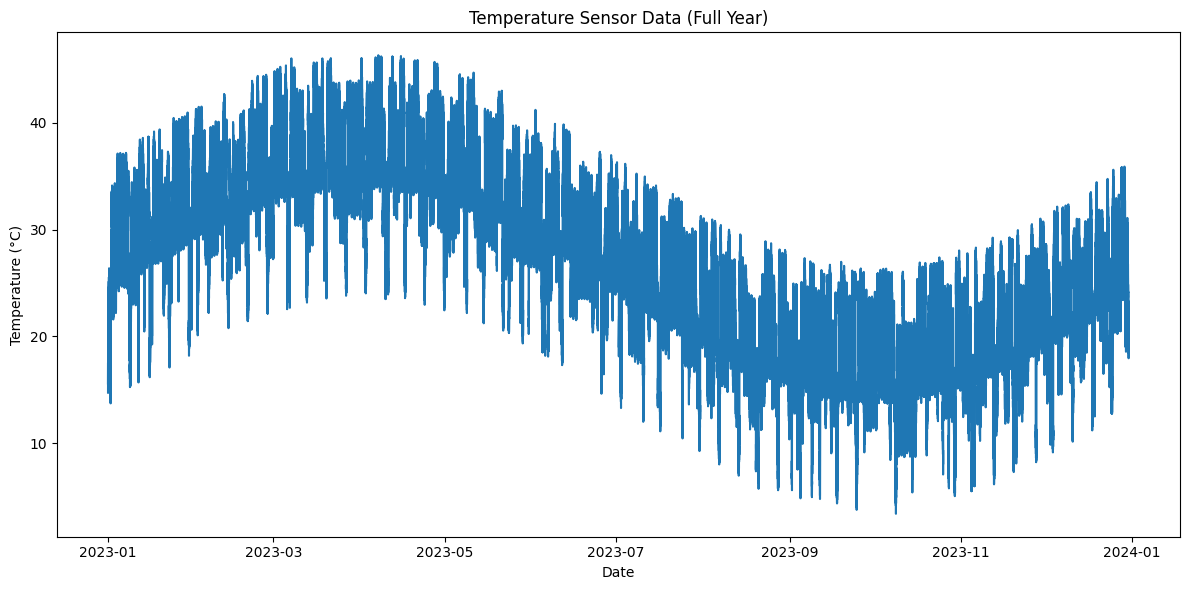

Generated 524161 data points from 2023-01-01 to 2023-12-31
                 date  temperature  capacity
0 2023-01-01 00:00:00    15.599202       0.0
1 2023-01-01 00:01:00    16.047573       0.0
2 2023-01-01 00:02:00    15.860598       0.0
3 2023-01-01 00:03:00    16.318468       0.0
4 2023-01-01 00:04:00    16.076077       0.0


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

def generate_temperature_sensor_data(start_date, end_date, freq='T'):
    # Create date range
    date_rng = pd.date_range(start=start_date, end=end_date, freq=freq)
    
    # Number of time steps
    n = len(date_rng)
    
    # Generate base signal (average daily temperature)
    base_temp = 20  # 20°C as base temperature
    
    # Add yearly seasonality (warmer in summer, cooler in winter)
    yearly_seasonality = 10 * np.sin(2 * np.pi * np.arange(n) / (365 * 24 * 60))
    
    # Add daily seasonality (warmer during day, cooler at night)
    time_of_day = date_rng.hour + date_rng.minute / 60
    daily_seasonality = 5 * np.sin(2 * np.pi * (time_of_day - 4) / 24)  # Peak at 4 PM
    
    # Generate machine capacity data
    capacity = generate_machine_capacity(date_rng)
    
    # Add some noise
    noise = np.random.normal(0, 0.5, n)
    
    # Combine all components
    temperature = base_temp + yearly_seasonality + daily_seasonality + 10 * capacity + noise
    
    # Ensure temperature stays within realistic bounds (e.g., 0°C to 60°C)
    temperature = np.clip(temperature, 0, 60)
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': date_rng,
        'temperature': temperature,
        'capacity': capacity
    })
    
    return df

def generate_machine_capacity(date_rng):
    capacity = np.zeros(len(date_rng))
    i = 0
    while i < len(date_rng):
        # Check if it's Sunday
        if date_rng[i].dayofweek == 6:  # 6 represents Sunday
            # On Sundays, mostly idle with occasional low capacity
            level = random.choices([0.0, 0.25], weights=[0.9, 0.1])[0]
            duration = 24 * 60  # Full day
        else:
            # For other days, use the original logic
            level = random.choices([1.0, 0.75, 0.5, 0.0], weights=[0.4, 0.3, 0.2, 0.1])[0]
            if level == 0.0:
                duration = random.randint(1, 8) * 60  # Idle periods: 1-8 hours
            else:
                duration = random.randint(4, 48) * 60  # Active periods: 4-48 hours
        
        duration = min(duration, len(date_rng) - i)  # Ensure we don't exceed array bounds
        
        capacity[i:i+duration] = level
        i += duration
    
    return capacity

# Generate dummy data
start_date = '2023-01-01'
end_date = '2023-12-31'
dummy_data = generate_temperature_sensor_data(start_date, end_date)

# Save to CSV
dummy_data.to_csv('temperature_sensor_data.csv', index=False)

# Plot a week of data to see the daily pattern clearly
one_week = dummy_data[dummy_data['date'].between('2023-07-01', '2023-07-07')]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ax1.plot(one_week['date'], one_week['temperature'])
ax1.set_title('Temperature Sensor Data (One Week in July)')
ax1.set_ylabel('Temperature (°C)')

ax2.plot(one_week['date'], one_week['capacity'])
ax2.set_title('Machine Capacity')
ax2.set_ylabel('Capacity (%)')
ax2.set_ylim(0, 1.1)

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the entire year to see the yearly pattern
plt.figure(figsize=(12, 6))
plt.plot(dummy_data['date'], dummy_data['temperature'])
plt.title('Temperature Sensor Data (Full Year)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.show()

print(f"Generated {len(dummy_data)} data points from {start_date} to {end_date}")
print(dummy_data.head())

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the data
data = pd.read_csv('temperature_sensor_data.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Decompose the temperature time series
# It is thw to apply different formula for extracting the features for the machine learning model
decomposition = seasonal_decompose(data['temperature'], model='additive', period=1440)  # 1440 minutes per day

# # Add decomposition components to the dataframe
# Seasonal decomposition is a technique used in time series analysis to decompose a time series into its constituent components: trend, seasonal, and residual (or irregular) components. This helps in understanding the underlying patterns in the data and can be useful for forecasting, anomaly detection, and other analytical tasks.

# Components of Seasonal Decomposition
# Trend: This component represents the long-term progression of the series. It shows the overall direction of the data, whether it's increasing, decreasing, or stable over time.

# Seasonal: This component captures the repeating short-term cycle in the series. It reflects regular patterns that occur at specific periods (such as monthly, quarterly, or yearly).

# Residual (Irregular): This component represents the random noise or irregular variations in the series that are not explained by the trend or seasonal components. It includes all the irregular fluctuations.

# Types of Seasonal Decomposition
# There are mainly two types of seasonal decomposition techniques:

# Additive Decomposition: This assumes that the components add together to make the time series. It is used when the seasonal variations are roughly constant over time.
# Multiplicative Decomposition: This assumes that the components multiply together to make the time series. It is used when the seasonal variations change proportionally over time.
data['temperature_trend'] = decomposition.trend
data['temperature_seasonal'] = decomposition.seasonal
data['temperature_residual'] = decomposition.resid

# Feature engineering
# TODO: Reason
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['is_sunday'] = (data.index.dayofweek == 6).astype(int)
data['month'] = data.index.month

# Calculate rolling statistics

data['rolling_mean_temp'] = data['temperature'].rolling(window=60).mean()
data['rolling_std_temp'] = data['temperature'].rolling(window=60).std()

# Create lagged features
# Lagged features in machine learning refer to past values of a time series that are used as features for forecasting or predicting future values. These features capture the temporal dependencies and patterns in the data.
# Why Use Lagged Features?
# Temporal Dependencies: Many time series have dependencies on past values. For example, stock prices, weather patterns, and sales data often depend on their historical values.
# Improving Model Performance: Including lagged features can improve the predictive power of models by providing more context about the past behavior of the time series.
# Creating Lagged Features
# To create lagged features, you shift the time series data by a certain number of time steps (lags). 
data['temp_lag_1h'] = data['temperature'].shift(60)
data['temp_lag_1d'] = data['temperature'].shift(1440)

# Drop rows with NaN values resulting from rolling calculations and lags
data = data.dropna()

# Prepare features for the model (excluding capacity-related features)
features = ['temperature', 'temperature_residual', 'hour', 'day_of_week', 'is_sunday', 'month', 
            'rolling_mean_temp', 'rolling_std_temp', 'temp_lag_1h', 'temp_lag_1d']
X = data[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train the Isolation Forest model
# TODO: Reason
contamination = 0.01  # Adjust this based on expected anomaly rate
model = IsolationForest(contamination=contamination, random_state=42)
model.fit(X_scaled)

# Predict anomalies
data['anomaly'] = model.predict(X_scaled)

In [6]:
X_scaled[0]

array([-0.47623724,  2.01447709, -1.66013213, -1.49709091, -0.40462767,
       -1.6091689 , -1.33230416,  1.05846815, -1.37144357, -1.33685349])

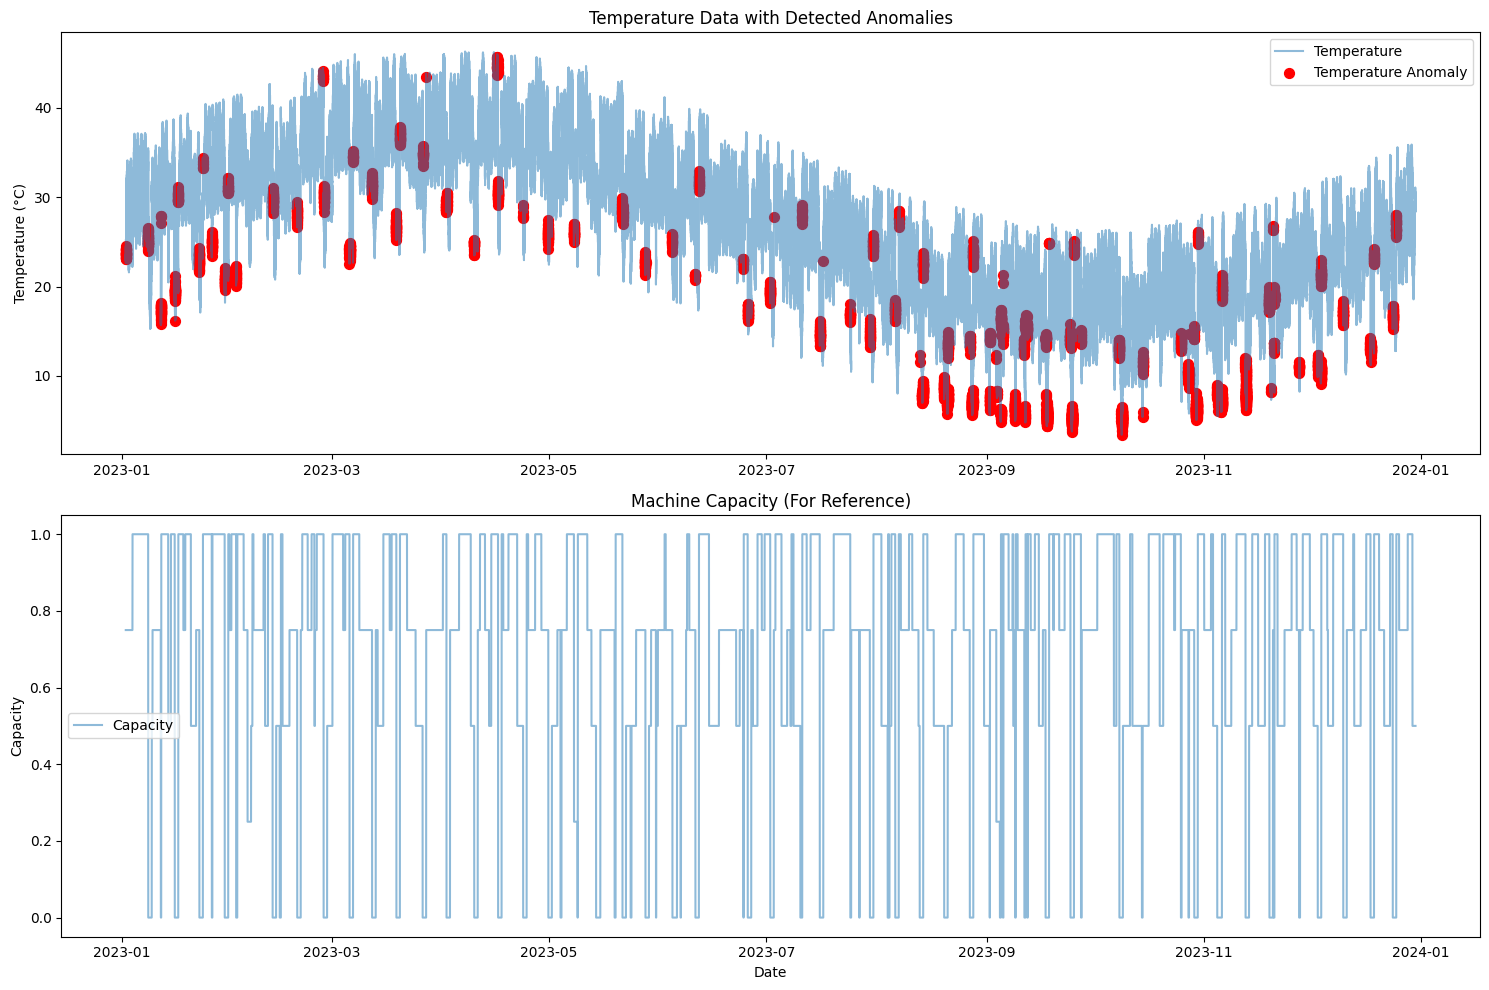

Total number of detected temperature anomalies: 5219
Percentage of temperature anomalies: 1.00%


In [3]:
# Plot the results
plt.figure(figsize=(15, 10))

# Temperature plot with anomalies
plt.subplot(2, 1, 1)
plt.plot(data.index, data['temperature'], label='Temperature', alpha=0.5)
plt.scatter(data[data['anomaly'] == -1].index, 
            data[data['anomaly'] == -1]['temperature'], 
            color='red', label='Temperature Anomaly', s=50)
plt.title('Temperature Data with Detected Anomalies')
plt.ylabel('Temperature (°C)')
plt.legend()

# Capacity plot for reference
plt.subplot(2, 1, 2)
plt.plot(data.index, data['capacity'], label='Capacity', alpha=0.5)
plt.title('Machine Capacity (For Reference)')
plt.xlabel('Date')
plt.ylabel('Capacity')
plt.legend()

plt.tight_layout()
plt.show()

# Print some statistics
total_anomalies = (data['anomaly'] == -1).sum()
print(f"Total number of detected temperature anomalies: {total_anomalies}")
print(f"Percentage of temperature anomalies: {total_anomalies / len(data) * 100:.2f}%")

# Optionally, save the results
data.to_csv('temperature_data_with_anomalies.csv')

Certainly! I'll create a more robust anomaly detection model that can handle trends, seasonal patterns, and variations in machine capacity. We'll use a combination of techniques to achieve this:

Decomposition of the time series to handle trends and seasonality.
Use of multiple features, including lagged values and rolling statistics.
Isolation Forest for anomaly detection, which is robust against various data patterns.
A separate check for capacity anomalies.

Removed capacity-related features from the anomaly detection model:

Removed 'capacity' and 'rolling_mean_capacity' from the features list.


Simplified anomaly detection:

Now only using the Isolation Forest model for temperature anomalies.
Removed the separate capacity anomaly detection.


Updated the plotting:

The top subplot now only shows temperature data with temperature anomalies.
The bottom subplot shows capacity data for reference, without marking any anomalies.


Updated statistics:

Now only counting and reporting temperature anomalies.



This version of the code focuses solely on detecting temperature anomalies while still allowing you to visually correlate these anomalies with the machine's capacity. The capacity plot is included for reference, making it easier to see if there's any relationship between temperature anomalies and machine capacity changes.
Remember, the Isolation Forest model is now trained only on temperature-related features, so it will be more sensitive to unusual temperature patterns regardless of the machine's capacity. You may need to adjust the contamination parameter to fine-tune the anomaly detection sensitivity based on your specific requirements.


The Isolation Forest (iForest) is an anomaly detection algorithm that identifies outliers in data by isolating observations. It operates under the premise that anomalies are "few and different," meaning they are easier to isolate than normal observations.

Key Concepts of Isolation Forest
Isolation: Anomalies are data points that are few and different, thus they are easier to isolate.
Random Partitioning: The algorithm randomly selects a feature and then randomly selects a split value between the maximum and minimum values of the selected feature.
Isolation Trees: The process of random partitioning is represented by trees. Each data point is isolated through recursive partitioning.
How Isolation Forest Works
Building Isolation Trees:

Create multiple decision trees (called isolation trees or iTrees) by randomly selecting a feature and a split value.
Partition the data recursively until each data point is isolated or a specified tree depth is reached.
Scoring:

The path length from the root to a leaf for each data point is calculated.
Shorter paths indicate anomalies because they require fewer splits to be isolated.
Anomaly Score:

The anomaly score for a data point is based on the average path length over all trees.
Anomalies have shorter average path lengths compared to normal points.
Steps of Isolation Forest
Training:

Fit the model on the training data by constructing an ensemble of isolation trees.
Scoring:

Calculate the anomaly score for each data point in the training and test sets.
Anomaly scores range between 0 and 1, with scores closer to 1 indicating a higher likelihood of being an anomaly.
Advantages of Isolation Forest
Efficiency: It has a linear time complexity with a low constant, making it efficient even for large datasets.
Scalability: Can handle high-dimensional data efficiently.
Interpretability: The model is relatively easy to understand as it is based on decision trees.

The contamination parameter in the Isolation Forest algorithm is an important setting that determines the expected proportion of anomalies in the dataset. It influences how the model identifies and scores anomalies.

Understanding Contamination
Definition:

The contamination parameter specifies the proportion of the dataset that is assumed to be outliers or anomalies.
It is a value between 0 and 0.5. A value of 0 means no contamination (no anomalies), and a value of 0.5 means 50% of the data is considered anomalous.
Impact on Model:

Threshold Determination: The contamination rate helps the model decide the threshold for classifying a data point as an anomaly. If the contamination is set to 0.1 (10%), the model will label the top 10% of data points with the highest anomaly scores as anomalies.
Sensitivity: A higher contamination value makes the model more sensitive, identifying more data points as anomalies. A lower contamination value makes it less sensitive, identifying fewer data points as anomalies.
Choosing the Contamination Value
Domain Knowledge:

Ideally, the contamination value should be set based on domain knowledge or prior understanding of the dataset. For example, in a financial fraud detection system, if historical data shows that 2% of transactions are fraudulent, setting contamination to 0.02 would be appropriate.
Data-Driven Approach:

If domain knowledge is unavailable, you can use a data-driven approach. This might involve cross-validation or using statistical methods to estimate the proportion of anomalies.
Trial and Error:

In some cases, it may be necessary to experiment with different contamination values and evaluate the model's performance using appropriate metrics to find the best setting.


In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Create sample training data
train_data = pd.DataFrame({
    'date': pd.date_range(start='2023-01-01 00:00:00', periods=1000, freq='T'),
    'temperature': np.random.normal(loc=20, scale=5, size=1000),
    'capacity': np.zeros(1000)
})
train_data.set_index('date', inplace=True)

# Feature engineering for training data
train_data['hour'] = train_data.index.hour
train_data['day_of_week'] = train_data.index.dayofweek
train_data['rolling_mean_temp'] = train_data['temperature'].rolling(window=30).mean()
train_data['rolling_std_temp'] = train_data['temperature'].rolling(window=30).std()
train_data['temp_lag_1h'] = train_data['temperature'].shift(60)

# Drop rows with NaN values
train_data = train_data.dropna()

# Define features
features = ['temperature', 'hour', 'day_of_week', 'rolling_mean_temp', 'rolling_std_temp', 'temp_lag_1h']

# Prepare features for training
X_train = train_data[features]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train the Isolation Forest model
contamination = 0.01  # Adjust based on expected anomaly rate
model = IsolationForest(contamination=contamination, random_state=42)
model.fit(X_train_scaled)

# Create dummy test data (2 rows)
test_data = pd.DataFrame({
    'date': pd.date_range(start='2023-01-15 00:00:00', periods=2, freq='T'),
    'temperature': [22.5, 35.0],  # Second temperature is abnormally high
    'capacity': [0, 0]
})
test_data.set_index('date', inplace=True)

# Feature engineering for test data
test_data['hour'] = test_data.index.hour
test_data['day_of_week'] = test_data.index.dayofweek
test_data['rolling_mean_temp'] = 22.5  # Assuming this is the average
test_data['rolling_std_temp'] = 5.0    # Assuming this is the standard deviation
test_data['temp_lag_1h'] = 22.5        # Assuming this is the temperature from 1 hour ago

# Function to predict anomaly for a single instance
def predict_anomaly(instance):
    instance_scaled = scaler.transform(instance.reshape(1, -1))
    prediction = model.predict(instance_scaled)
    return prediction[0]

# Predict for each row in the test data
for i, row in test_data.iterrows():
    # Prepare the instance
    instance = row[features].values
    
    # Predict
    anomaly = predict_anomaly(instance)
    
    # Print result
    print(f"Date: {i}, Temperature: {row['temperature']:.2f}, Anomaly: {'Yes' if anomaly == -1 else 'No'}")

/tmp/ipykernel_33/2342651625.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'date': pd.date_range(start='2023-01-01 00:00:00', periods=1000, freq='T'),


Date: 2023-01-15 00:00:00, Temperature: 22.50, Anomaly: No
Date: 2023-01-15 00:01:00, Temperature: 35.00, Anomaly: Yes


/tmp/ipykernel_33/2342651625.py:41: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  'date': pd.date_range(start='2023-01-15 00:00:00', periods=2, freq='T'),
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
